In [2]:
import os
import numpy as np 
import pandas as pd 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, HTML
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tesla-stock-price-history/Tesla_stock_data.csv


In [3]:
df = pd.read_csv("/kaggle/input/tesla-stock-price-history/Tesla_stock_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df["weekday"] = df["Date"].dt.day_name()
df["year"] = df["Date"].dt.year 

In [4]:
tesla_trend_periods = [
    {
        "trend": "Flat → Moderate growth",
        "start_date": "2010-06-29",
        "end_date": "2012-12-31"
    },
    {
        "trend": "Rapid Rise",
        "start_date": "2013-03-01",
        "end_date": "2014-09-30"
    },
    {
        "trend": "Sideways with dips",
        "start_date": "2015-01-01",
        "end_date": "2018-12-31"
    },
    {
        "trend": "Gradual Climb",
        "start_date": "2019-01-01",
        "end_date": "2019-12-31"
    },
    {
        "trend": "Explosive Rally",
        "start_date": "2020-01-01",
        "end_date": "2021-11-04"
    },
    {
        "trend": "Sharp Decline",
        "start_date": "2021-11-05",
        "end_date": "2022-12-31"
    },
    {
        "trend": "Moderate Recovery",
        "start_date": "2023-01-01",
        "end_date": "2023-12-31"
    },
    {
        "trend": "Bullish Momentum",
        "start_date": "2024-01-01",
        "end_date": "2024-12-31"
    },
    {
        "trend": "Bearish Correction",
        "start_date": "2025-01-01",
        "end_date": "2025-06-16"
    }
]


In [5]:
def plot_tesla_chart_from_trend(df, trend_period):
    start_date = trend_period['start_date']
    end_date = trend_period['end_date']
    trend_name = trend_period['trend']
    # Ensure datetime
    df['date'] = pd.to_datetime(df['Date'])
    # Handle 'Present' end_date
    if end_date.lower() == "present":
        end_date = pd.Timestamp.today().strftime("%Y-%m-%d")
    # Filter by date range
    df_filtered = df[(df['date'] >= pd.to_datetime(start_date)) &
                     (df['date'] <= pd.to_datetime(end_date))].sort_values('date').reset_index(drop=True)
    if df_filtered.empty:
        print(f"No data for: {trend_name} ({start_date} to {end_date})")
        return
    # Indicators
    df_filtered['SMA'] = df_filtered['Close'].rolling(window=10, min_periods=1).mean()
    df_filtered['BB_MID'] = df_filtered['Close'].rolling(window=20, min_periods=1).mean()
    df_filtered['BB_STD'] = df_filtered['Close'].rolling(window=20, min_periods=1).std()
    df_filtered['BB_UPPER'] = df_filtered['BB_MID'] + (2 * df_filtered['BB_STD'])
    df_filtered['BB_LOWER'] = df_filtered['BB_MID'] - (2 * df_filtered['BB_STD'])
    delta = df_filtered['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    df_filtered['RSI'] = 100 - (100 / (1 + rs))
    # Plot
    fig, (ax, ax_rsi) = plt.subplots(nrows=2, figsize=(16, 8), gridspec_kw={'height_ratios': [4, 1]})
    STEP_PER_DAY = 4
    x_positions = [i * STEP_PER_DAY for i in range(len(df_filtered))]
    # Candlesticks
    for i, row in df_filtered.iterrows():
        color = 'green' if row['Close'] >= row['Open'] else 'red'
        x = x_positions[i]
        ax.plot([x, x], [row['Low'], row['High']], color=color, alpha=0.4)
        ax.add_patch(patches.Rectangle((x - 0.5, min(row['Open'], row['Close'])),
                                       1, abs(row['Close'] - row['Open']),
                                       color=color, alpha=0.4))
    # SMA & Bollinger
    ax.plot([x + 1.5 for x in x_positions], df_filtered['SMA'], linestyle='--', color='blue', label='SMA')
    ax.plot([x + 1.5 for x in x_positions], df_filtered['BB_UPPER'], linestyle='--', color='purple', linewidth=0.8)
    ax.plot([x + 1.5 for x in x_positions], df_filtered['BB_LOWER'], linestyle='--', color='purple', linewidth=0.8)
    # Volume
    ax2 = ax.twinx()
    ax2.bar(x_positions, df_filtered['Volume'], width=1.0, color='grey', alpha=0.2)
    ax2.set_ylim(0, df_filtered['Volume'].max() * 3)
    ax2.set_ylabel("Volume")
    # Ticks
    tick_spacing = STEP_PER_DAY * 10
    tick_positions = list(range(0, len(df_filtered) * STEP_PER_DAY, tick_spacing))
    tick_labels = [str(df_filtered.loc[pos // STEP_PER_DAY]['date'].date()) if pos // STEP_PER_DAY < len(df_filtered) else '' for pos in tick_positions]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45)

    ax.set_xlim(0, len(df_filtered) * STEP_PER_DAY)
    ax.set_ylim(df_filtered[['Low', 'High']].min().min(), df_filtered[['High']].max().max())
    ax.set_title(f"Tesla Trend: {trend_name} ({start_date} to {end_date})")
    ax.set_ylabel("Price")
    ax.grid(True, linestyle='--', alpha=0.3)
    # RSI
    ax_rsi.plot([x + 1.5 for x in x_positions], df_filtered['RSI'], color='orange')
    ax_rsi.axhline(70, linestyle='--', color='red', alpha=0.3)
    ax_rsi.axhline(30, linestyle='--', color='green', alpha=0.3)
    ax_rsi.set_ylim(0, 100)
    ax_rsi.set_ylabel("RSI")
    ax_rsi.set_xticks(tick_positions)
    ax_rsi.set_xticklabels(tick_labels, rotation=45)
    ax_rsi.grid(True, linestyle='--', alpha=0.2)
    plt.tight_layout()
    plt.show()

[d](https://media0.giphy.com/media/v1.Y2lkPTc5MGI3NjExbnZjejR0NnpoZGhraWEwNTZnMXV6bHdmOWJtZGtpc2R0ejdjZnQ5NiZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/1JesuN4zFH03kO1NB1/giphy.gif)

In [15]:
display(HTML("""
<div style="
  width: 100%;
  display: flex;
  justify-content: center;
  align-items: center;
  margin-top: 40px;
">
  <div style="
    padding: 20px;
    border-radius: 20px;
    background: #f0f0f3;
    box-shadow:
      8px 8px 16px #d1d9e6,
      -8px -8px 16px #ffffff;
  ">
    <img src="https://media0.giphy.com/media/v1.Y2lkPTc5MGI3NjExbnZjejR0NnpoZGhraWEwNTZnMXV6bHdmOWJtZGtpc2R0ejdjZnQ5NiZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/1JesuN4zFH03kO1NB1/giphy.gif"
         alt="Tesla GIF"
         style="width: 25vw; height: auto; border-radius: 12px;">
  </div>
</div>
"""))


<div style="background: #fdf6e3; padding: 24px; border-radius: 16px; box-shadow: 0 0 12px rgba(0,0,0,0.1); font-family: 'Segoe UI', Roboto, sans-serif; color: #000000;">
  <table style="width:100%; border-collapse: collapse; background-color: #fffaf0; border: 1px solid #ccc; border-radius: 12px; overflow: hidden;">
    <thead>
      <tr style="background-color: #e6ddc4;">
        <th style="padding: 14px 12px; text-align: left; border-bottom: 2px solid #ccc; color: #000000;">Period</th>
        <th style="padding: 14px 12px; text-align: left; border-bottom: 2px solid #ccc; color: #000000;">Trend</th>
        <th style="padding: 14px 12px; text-align: left; border-bottom: 2px solid #ccc; color: #000000;">Duration</th>
        <th style="padding: 14px 12px; text-align: left; border-bottom: 2px solid #ccc; color: #000000;">Highlights</th>
      </tr>
    </thead>
    <tbody>
      <tr style="background-color: #fefcf8;">
        <td style="padding: 12px;">1. IPO & Early Years</td>
        <td style="padding: 12px;">Flat → Moderate growth</td>
        <td style="padding: 12px;">2010-06-29 – 2012-12-31</td>
        <td style="padding: 12px;">IPO at 17 Dollars. Low production. Skepticism around EVs.</td>
      </tr>
      <tr style="background-color: #f5f0e6;">
        <td style="padding: 12px;">2. First Breakout</td>
        <td style="padding: 12px; color: #00aa88;">Rapid Rise</td>
        <td style="padding: 12px;">2013-03-01 – 2014-09-30</td>
        <td style="padding: 12px;">Model S success. Share price up ~800%.</td>
      </tr>
      <tr style="background-color: #fefcf8;">
        <td style="padding: 12px;">3. Plateau & Volatility</td>
        <td style="padding: 12px; color: #555555;">Sideways with dips</td>
        <td style="padding: 12px;">2015-01-01 – 2018-12-31</td>
        <td style="padding: 12px;">Model 3 production bottlenecks. Price stalls ~$50–$70.</td>
      </tr>
      <tr style="background-color: #f5f0e6;">
        <td style="padding: 12px;">4. Pre-Bull Run Base</td>
        <td style="padding: 12px; color: #0077cc;">Gradual Climb</td>
        <td style="padding: 12px;">2019-01-01 – 2019-12-31</td>
        <td style="padding: 12px;">Q3 earnings beat sparks optimism.</td>
      </tr>
      <tr style="background-color: #fefcf8;">
        <td style="padding: 12px;">5. Mega Bull Run</td>
        <td style="padding: 12px; color: #00aa88;">Explosive Rally</td>
        <td style="padding: 12px;">2020-01-01 – 2021-11-04</td>
        <td style="padding: 12px;">5:1 split, S&P inclusion, FSD hype. ~1600% surge.</td>
      </tr>
      <tr style="background-color: #f5f0e6;">
        <td style="padding: 12px;">6. Peak & Selloff</td>
        <td style="padding: 12px; color: #cc0000;">Sharp Decline</td>
        <td style="padding: 12px;">2021-11-05 – 2022-12-31</td>
        <td style="padding: 12px;">~65% drop. Twitter drama. Musk liquidates shares.</td>
      </tr>
      <tr style="background-color: #fefcf8;">
        <td style="padding: 12px;">7. Tech Recovery</td>
        <td style="padding: 12px; color: #228b22;">Moderate Recovery</td>
        <td style="padding: 12px;">2023-01-01 – 2023-12-31</td>
        <td style="padding: 12px;">AI surge, EV demand rebounds. Stock doubles.</td>
      </tr>
      <tr style="background-color: #f5f0e6;">
        <td style="padding: 12px;">8. 2024 Boom</td>
        <td style="padding: 12px; color: #00aa88;">Bullish Momentum</td>
        <td style="padding: 12px;">2024-01-01 – 2024-12-31</td>
        <td style="padding: 12px;">Robotaxi talk, FSD demo. ATH near $480.</td>
      </tr>
      <tr style="background-color: #fefcf8;">
        <td style="padding: 12px;">9. 2025 Mini-Crash</td>
        <td style="padding: 12px; color: #cc0000;">Bearish Correction</td>
        <td style="padding: 12px;">2025-01-01 – 2025-06-16</td>
        <td style="padding: 12px;">Sales dip. Regulatory pressure from EU & China.</td>
      </tr>
    </tbody>
  </table>
</div>


<div style="width: 100%; max-width: 900px; margin: 20px auto; padding: 25px; border-radius: 15px; background: #fffaf0; color: #222; font-family: 'Georgia', serif; font-size: 22px; font-weight: bold; text-align: center; text-transform: uppercase; letter-spacing: 1px; border: 1px solid #ccc; box-shadow: 2px 2px 8px rgba(0, 0, 0, 0.1);">
  Flat → Moderate growth<br><span style="font-size: 18px; font-weight: normal; text-transform: none;">2010-06-29 to 2012-12-31</span>
</div>

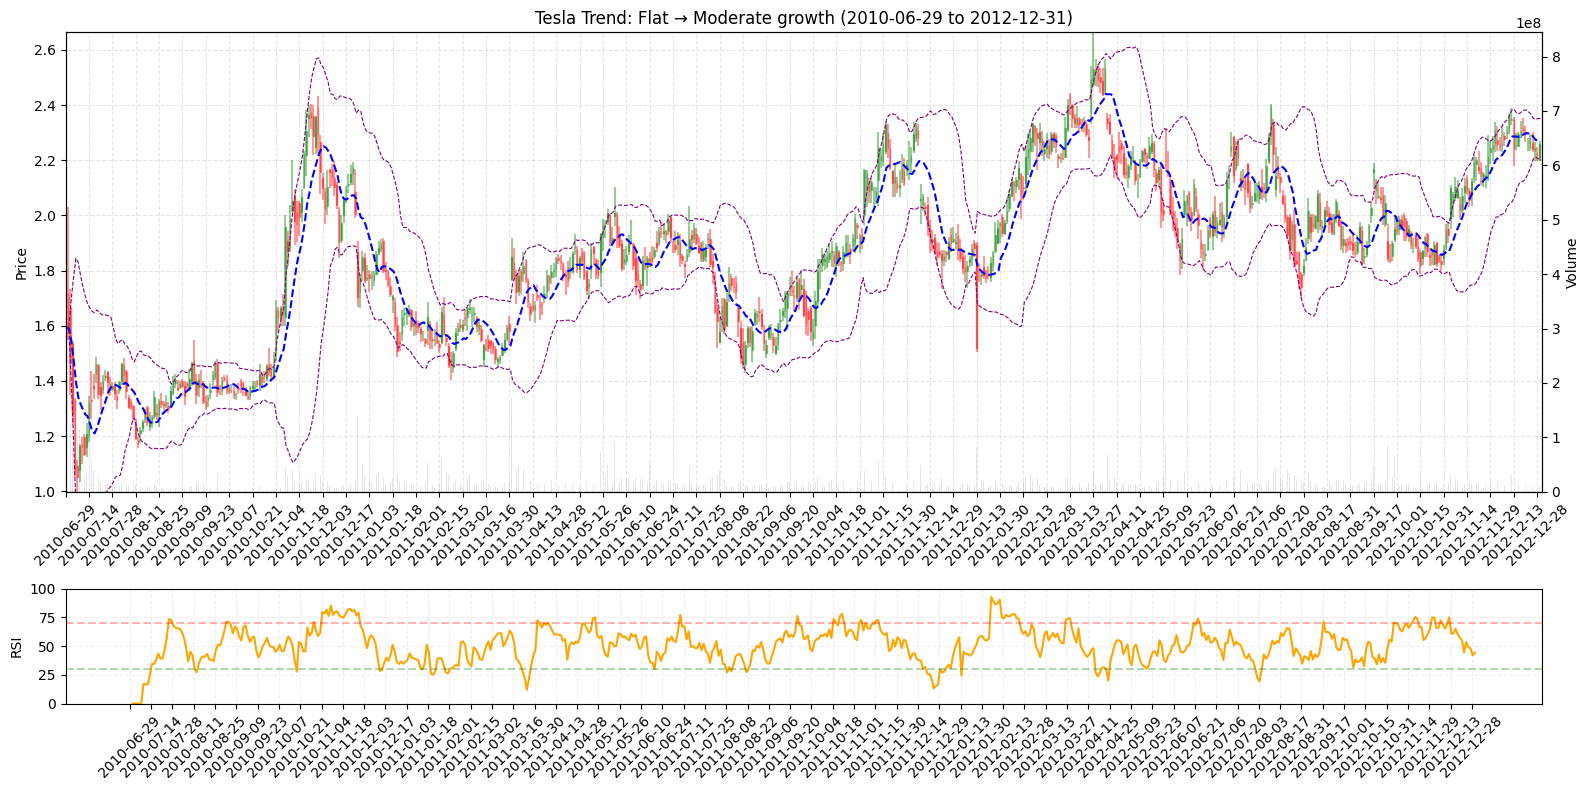

In [6]:
plot_tesla_chart_from_trend(df, tesla_trend_periods[0])

<div style="width: 100%; max-width: 900px; margin: 20px auto; padding: 25px; border-radius: 15px; background: #fffaf0; color: #222; font-family: 'Georgia', serif; font-size: 22px; font-weight: bold; text-align: center; text-transform: uppercase; letter-spacing: 1px; border: 1px solid #ccc; box-shadow: 2px 2px 8px rgba(0, 0, 0, 0.1);">
  Rapid Rise<br><span style="font-size: 18px; font-weight: normal; text-transform: none;">2013-03-01 to 2014-09-30</span>
</div>

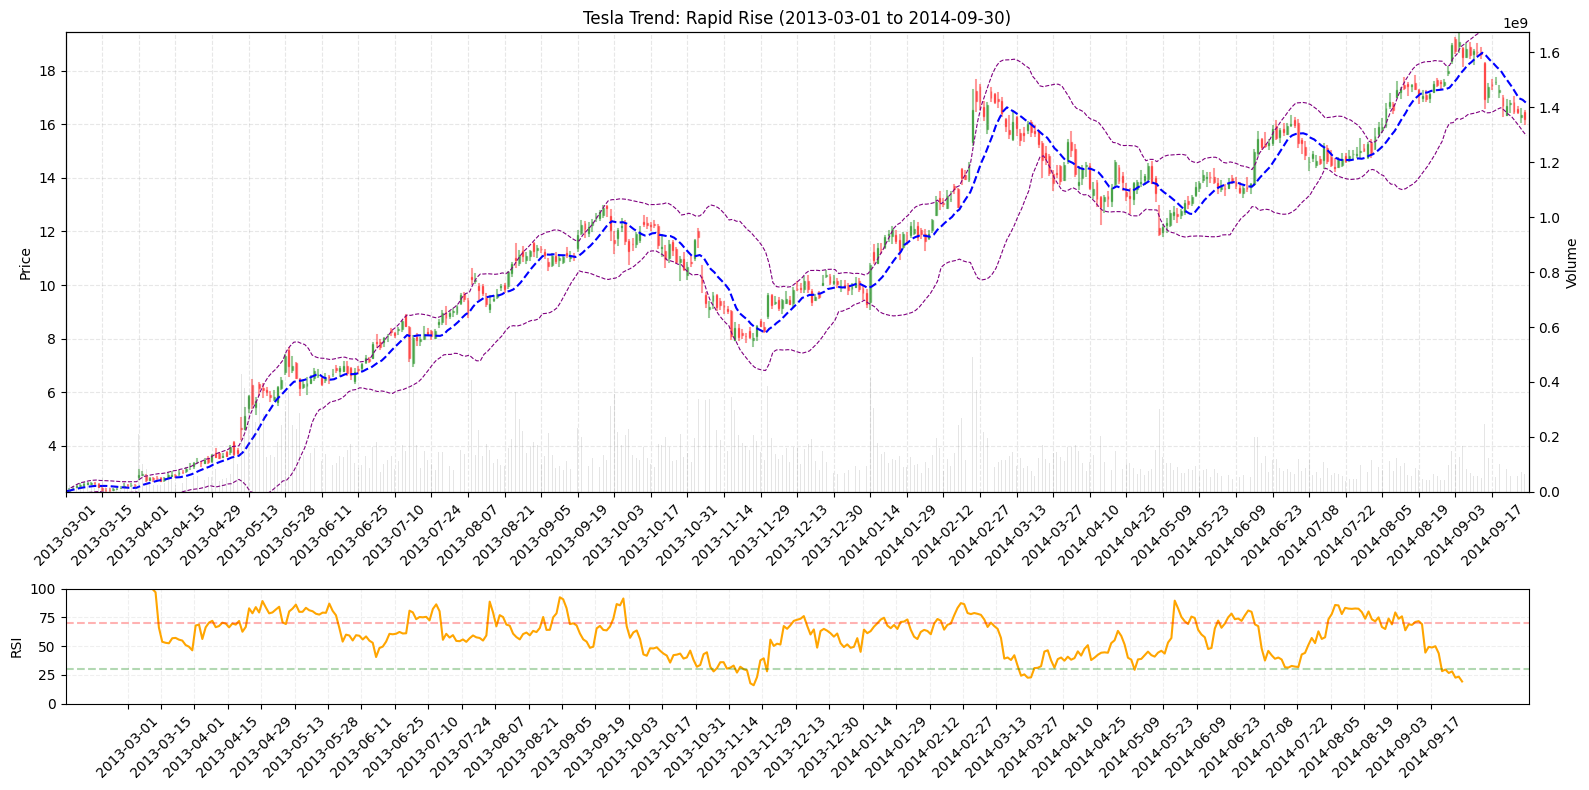

In [7]:
plot_tesla_chart_from_trend(df, tesla_trend_periods[1])

<div style="width: 100%; max-width: 900px; margin: 20px auto; padding: 25px; border-radius: 15px; background: #fffaf0; color: #222; font-family: 'Georgia', serif; font-size: 22px; font-weight: bold; text-align: center; text-transform: uppercase; letter-spacing: 1px; border: 1px solid #ccc; box-shadow: 2px 2px 8px rgba(0, 0, 0, 0.1);">
  Sideways with dips<br><span style="font-size: 18px; font-weight: normal; text-transform: none;">2015-01-01 to 2018-12-31</span>
</div>

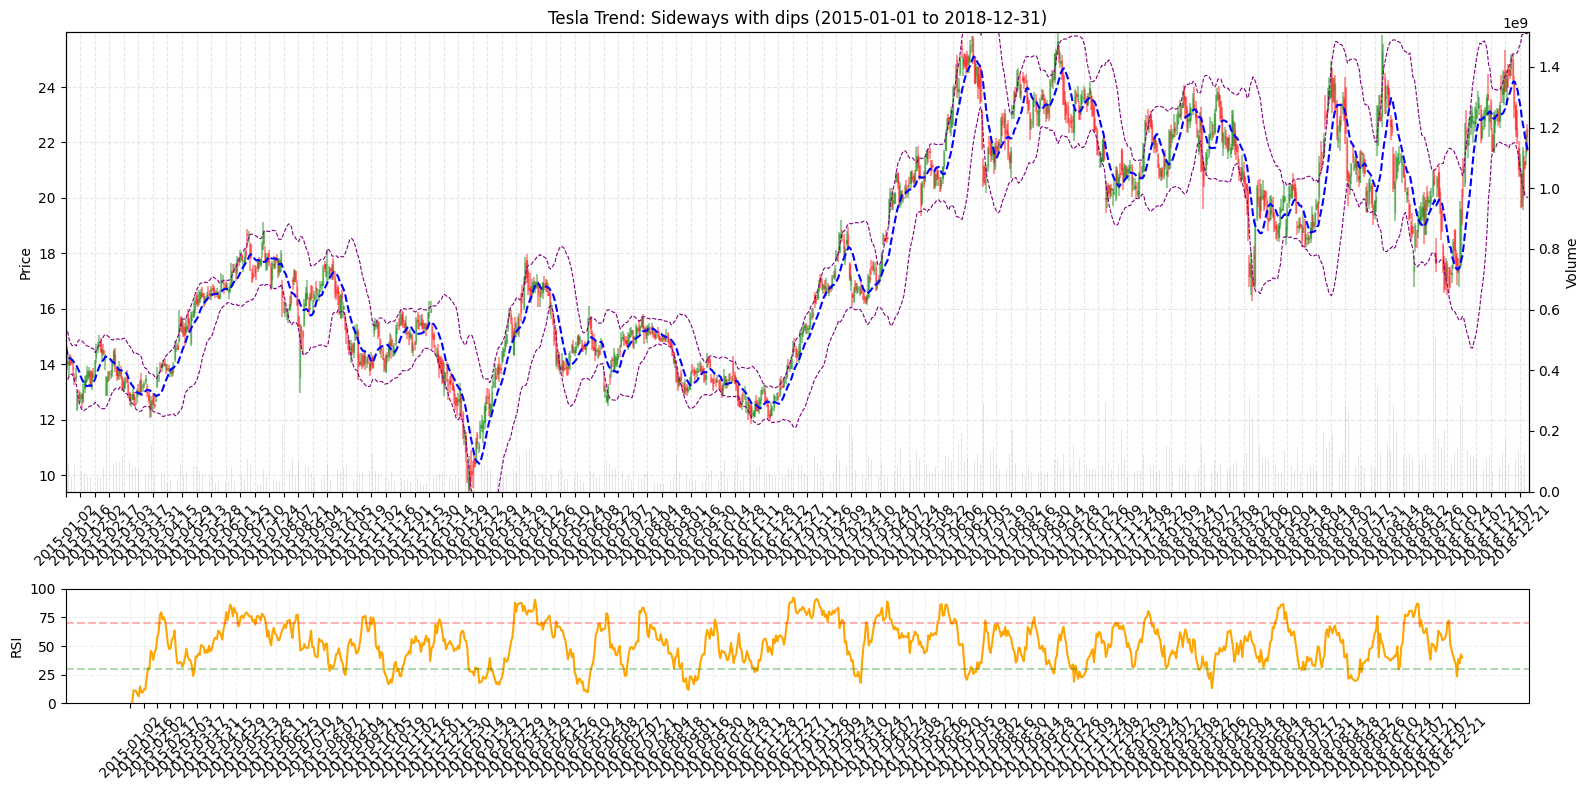

In [8]:
plot_tesla_chart_from_trend(df, tesla_trend_periods[2])

<div style="width: 100%; max-width: 900px; margin: 20px auto; padding: 25px; border-radius: 15px; background: #fffaf0; color: #222; font-family: 'Georgia', serif; font-size: 22px; font-weight: bold; text-align: center; text-transform: uppercase; letter-spacing: 1px; border: 1px solid #ccc; box-shadow: 2px 2px 8px rgba(0, 0, 0, 0.1);">
  Gradual Climb<br><span style="font-size: 18px; font-weight: normal; text-transform: none;">2019-01-01 to 2019-12-31</span>
</div>


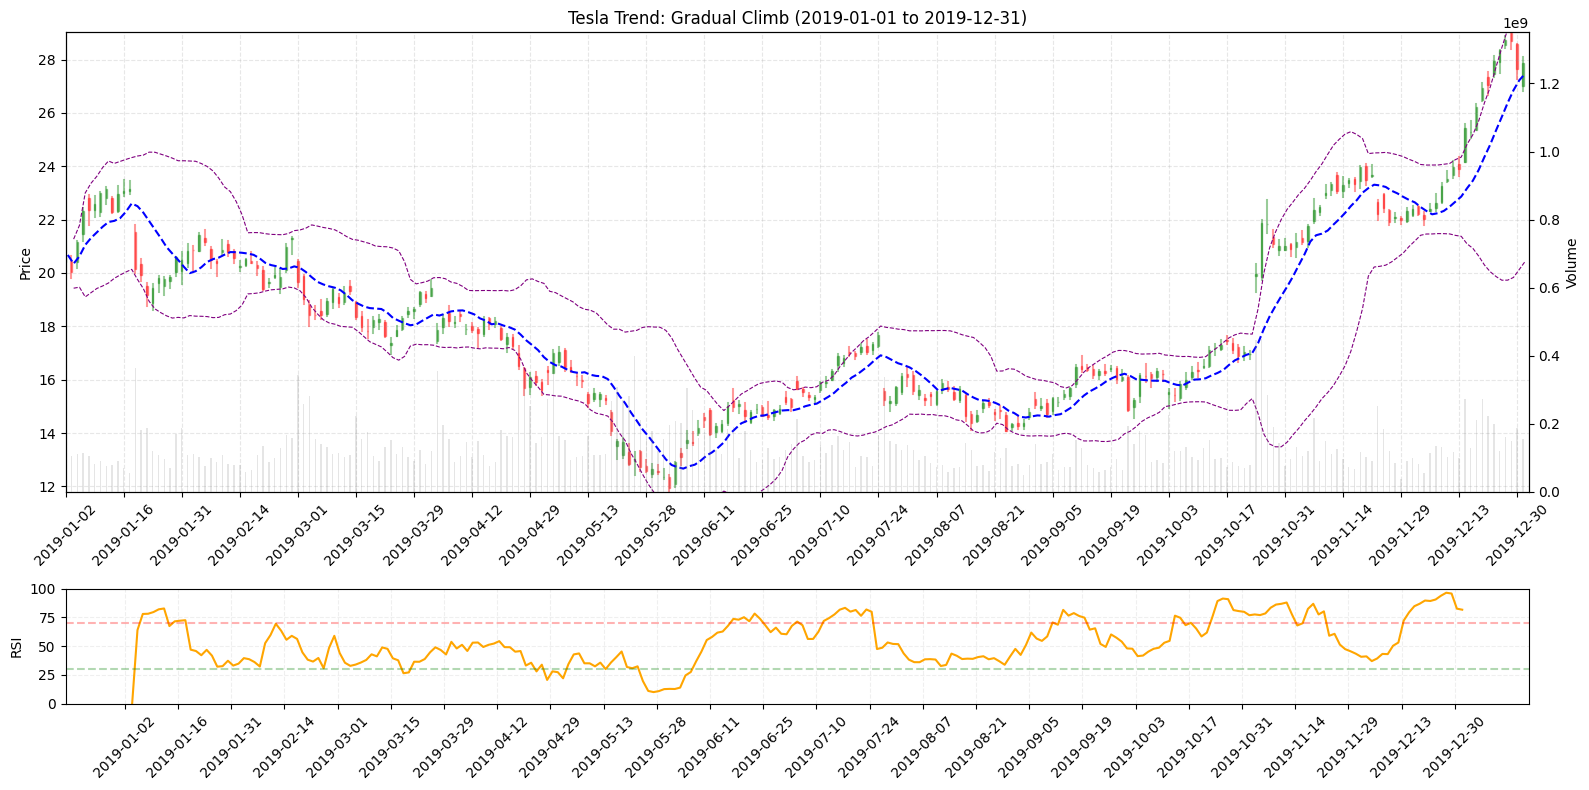

In [9]:
plot_tesla_chart_from_trend(df, tesla_trend_periods[3])

<div style="width: 100%; max-width: 900px; margin: 20px auto; padding: 25px; border-radius: 15px; background: #fffaf0; color: #222; font-family: 'Georgia', serif; font-size: 22px; font-weight: bold; text-align: center; text-transform: uppercase; letter-spacing: 1px; border: 1px solid #ccc; box-shadow: 2px 2px 8px rgba(0, 0, 0, 0.1);">
  Explosive Rally<br><span style="font-size: 18px; font-weight: normal; text-transform: none;">2020-01-01 to 2021-11-04</span>
</div>

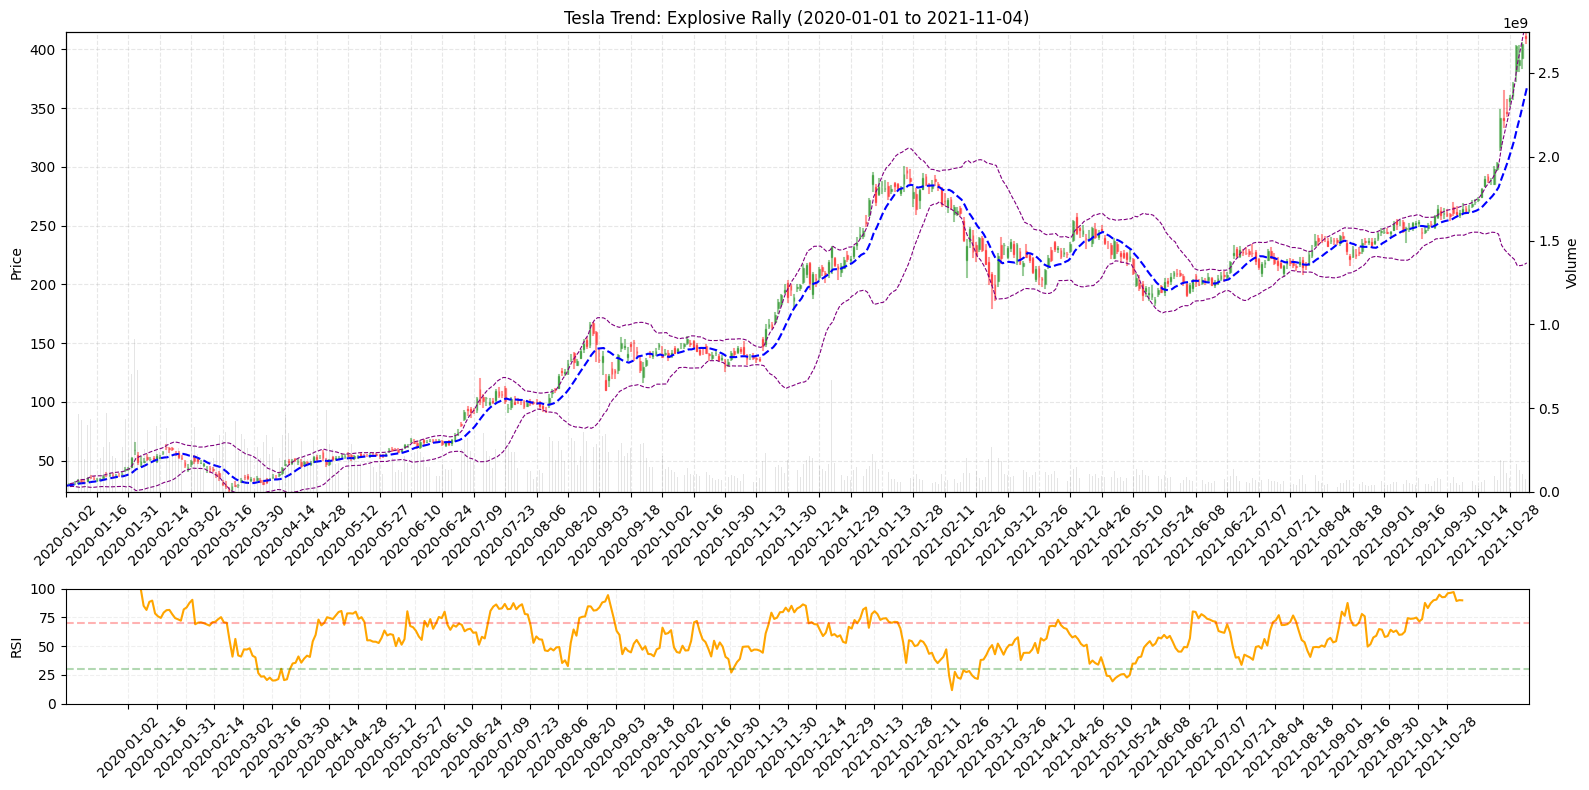

In [10]:
plot_tesla_chart_from_trend(df, tesla_trend_periods[4])

<div style="width: 100%; max-width: 900px; margin: 20px auto; padding: 25px; border-radius: 15px; background: #fffaf0; color: #222; font-family: 'Georgia', serif; font-size: 22px; font-weight: bold; text-align: center; text-transform: uppercase; letter-spacing: 1px; border: 1px solid #ccc; box-shadow: 2px 2px 8px rgba(0, 0, 0, 0.1);">
  Sharp Decline<br><span style="font-size: 18px; font-weight: normal; text-transform: none;">2021-11-05 to 2022-12-31</span>
</div>

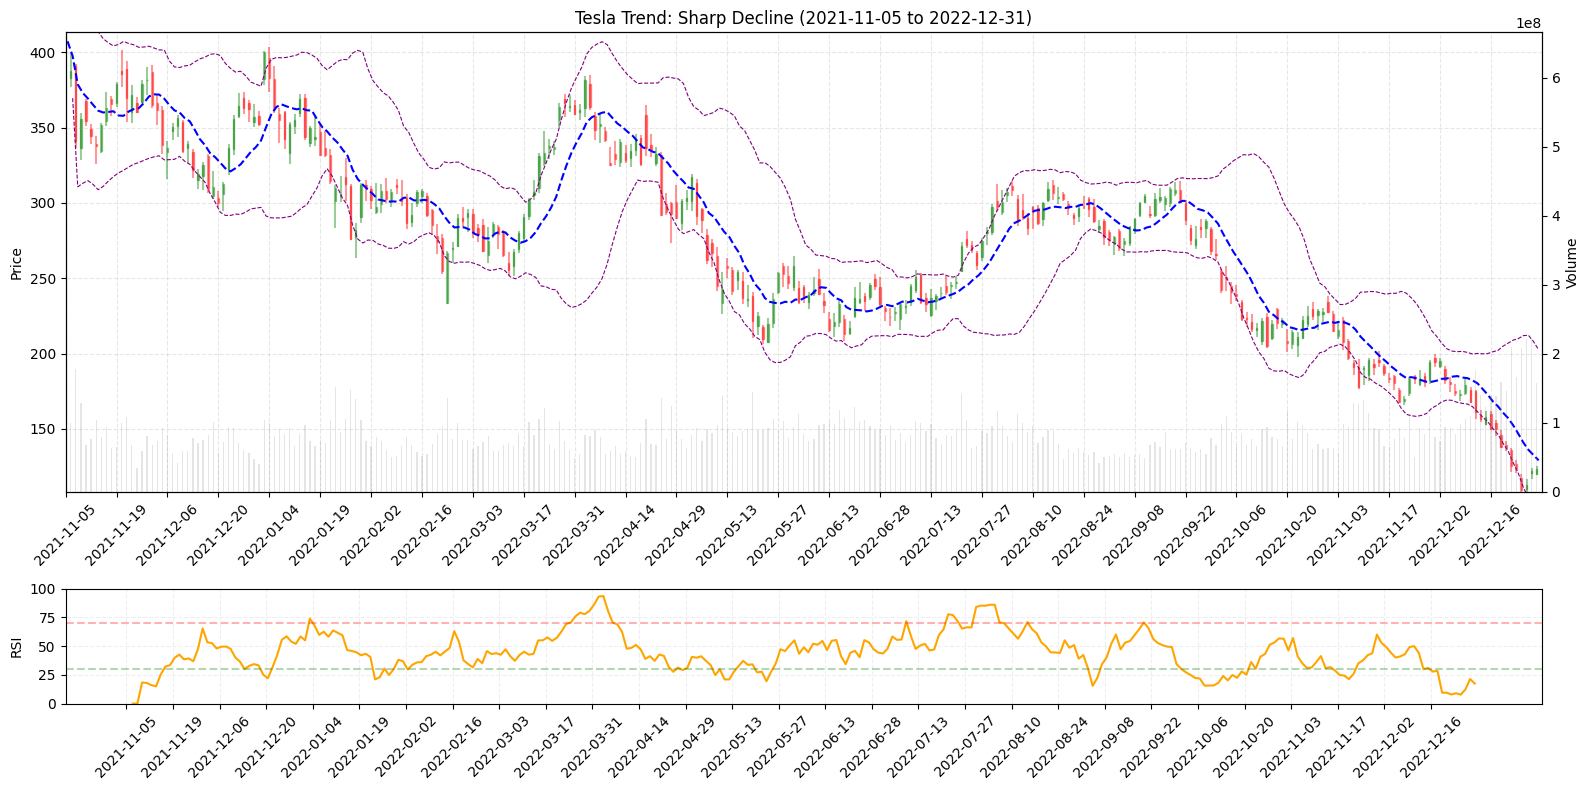

In [11]:
plot_tesla_chart_from_trend(df, tesla_trend_periods[5])

<div style="width: 100%; max-width: 900px; margin: 20px auto; padding: 25px; border-radius: 15px; background: #fffaf0; color: #222; font-family: 'Georgia', serif; font-size: 22px; font-weight: bold; text-align: center; text-transform: uppercase; letter-spacing: 1px; border: 1px solid #ccc; box-shadow: 2px 2px 8px rgba(0, 0, 0, 0.1);">
  Moderate Recovery<br><span style="font-size: 18px; font-weight: normal; text-transform: none;">2023-01-01 to 2023-12-31</span>
</div>

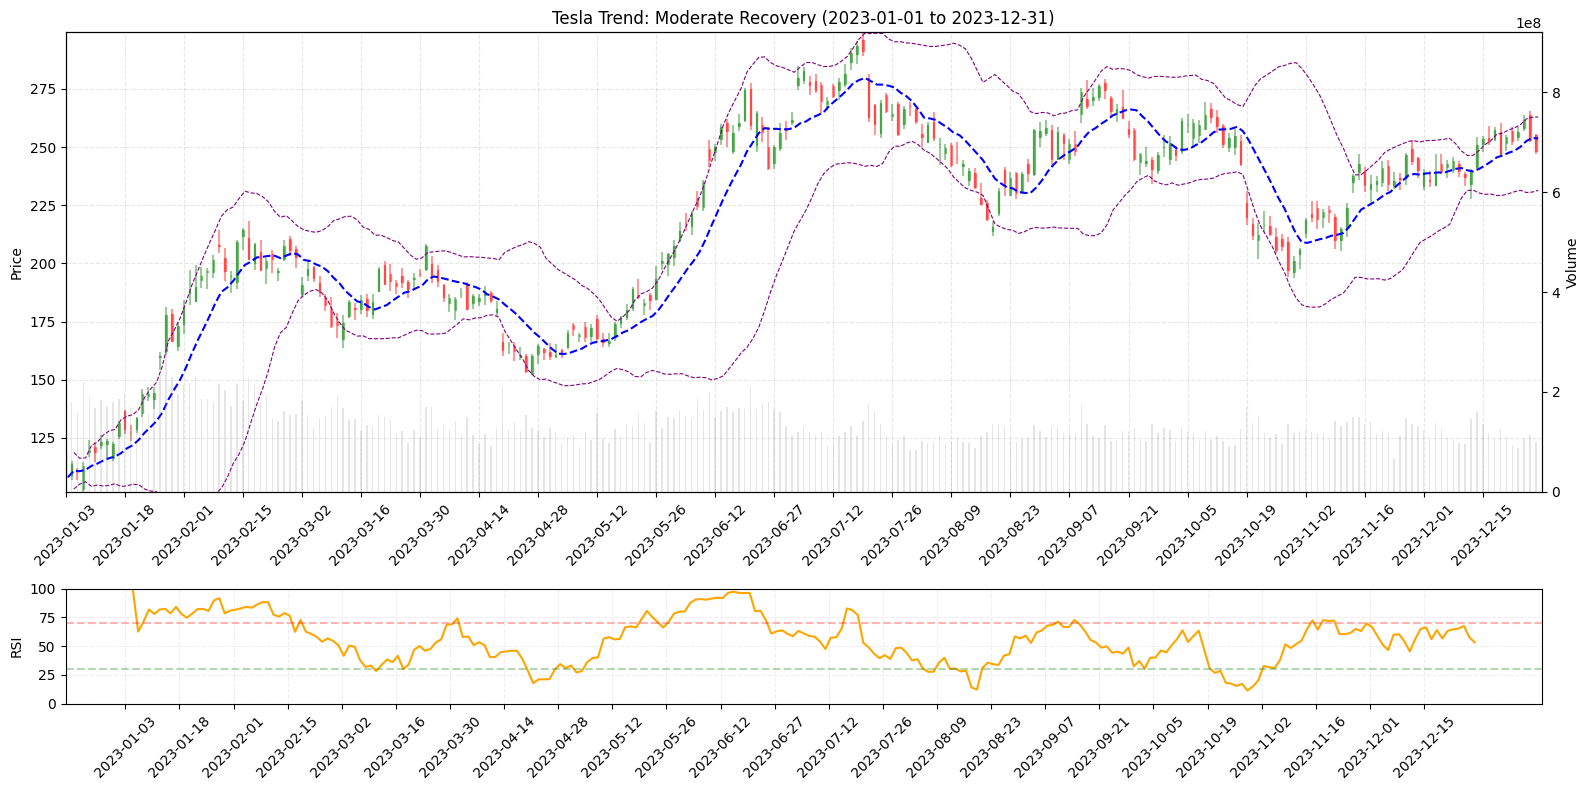

In [12]:
plot_tesla_chart_from_trend(df, tesla_trend_periods[6])

<div style="width: 100%; max-width: 900px; margin: 20px auto; padding: 25px; border-radius: 15px; background: #fffaf0; color: #222; font-family: 'Georgia', serif; font-size: 22px; font-weight: bold; text-align: center; text-transform: uppercase; letter-spacing: 1px; border: 1px solid #ccc; box-shadow: 2px 2px 8px rgba(0, 0, 0, 0.1);">
  Bullish Momentum<br><span style="font-size: 18px; font-weight: normal; text-transform: none;">2024-01-01 to 2024-12-31</span>
</div>


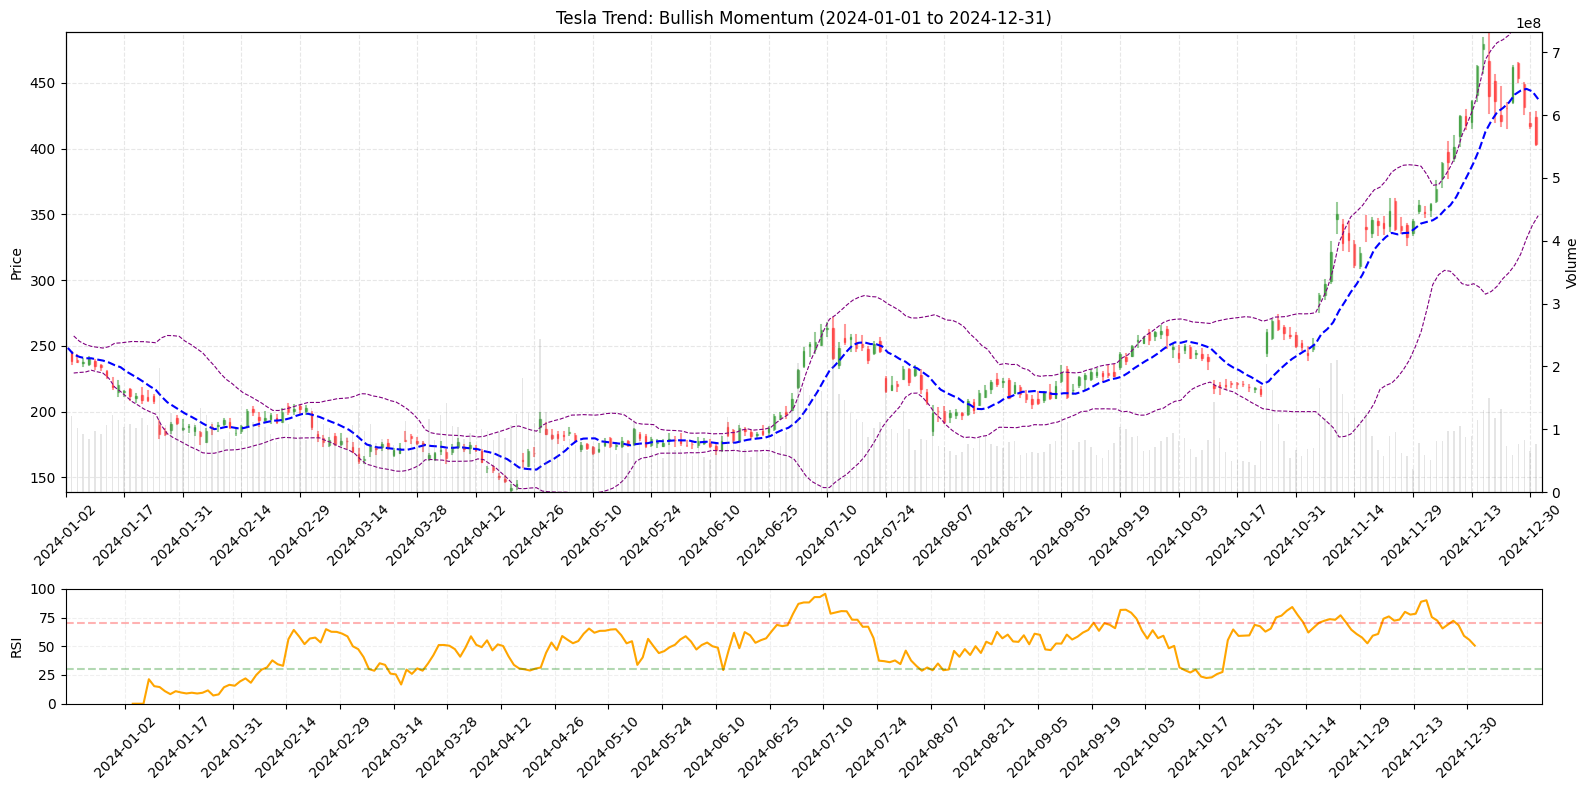

In [13]:
plot_tesla_chart_from_trend(df, tesla_trend_periods[7])

<div style="width: 100%; max-width: 900px; margin: 20px auto; padding: 25px; border-radius: 15px; background: #fffaf0; color: #222; font-family: 'Georgia', serif; font-size: 22px; font-weight: bold; text-align: center; text-transform: uppercase; letter-spacing: 1px; border: 1px solid #ccc; box-shadow: 2px 2px 8px rgba(0, 0, 0, 0.1);">
  Bearish Correction<br><span style="font-size: 18px; font-weight: normal; text-transform: none;">2025-01-01 to 2025-06-16</span>
</div>

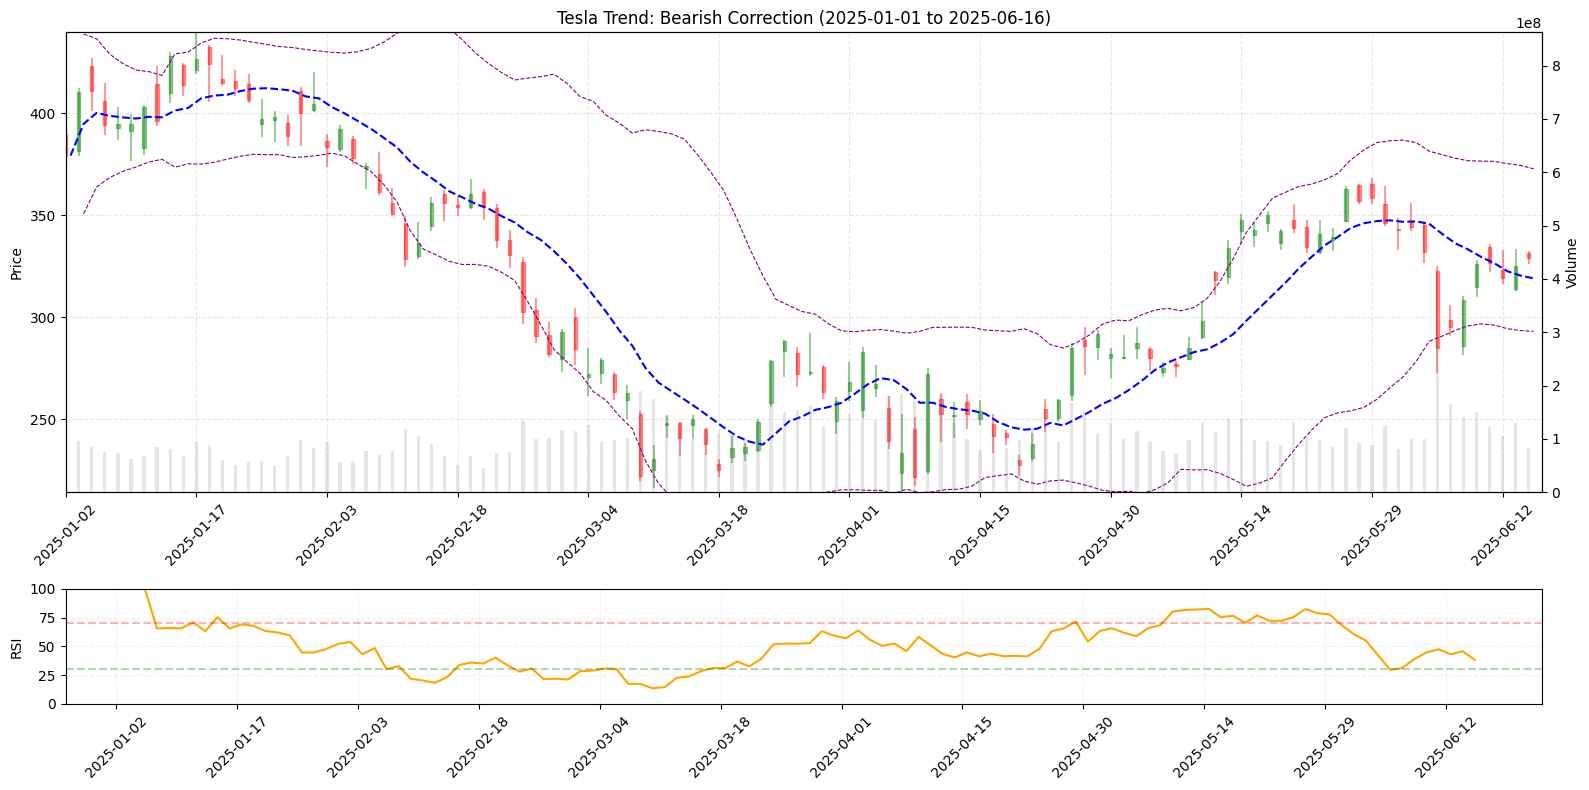

In [14]:
plot_tesla_chart_from_trend(df, tesla_trend_periods[8])

In [16]:
display(HTML("""
<div style="
  width: 100%;
  display: flex;
  justify-content: center;
  align-items: center;
  margin-top: 40px;
">
  <div style="
    padding: 20px;
    border-radius: 20px;
    background: #f0f0f3;
    box-shadow:
      8px 8px 16px #d1d9e6,
      -8px -8px 16px #ffffff;
  ">
    <img src="https://media0.giphy.com/media/v1.Y2lkPTc5MGI3NjExdzlkeGF4OXdwNTVqazBxaG95bXFkNTN1Z3Z5cm1nenV6Yml1eG9rcCZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/GrIXoWfyqVRCShsBHn/giphy.gif"
         alt="Tesla GIF"
         style="width: 25vw; height: auto; border-radius: 12px;">
  </div>
</div>
"""))